# Adversarial autoencoder

Implementation of the adversarial autoencoder proposed in Makhzani et al., 2015 (https://arxiv.org/abs/1511.05644)

## Background

The adverarial autoencoder introduces a regularization term on the hidden representation of autoencoders to match an arbitrary prior. The regularization is achieved by training a network (called discriminator network in the following) to discriminate between samples from the latent representation of the autoencoder and samples from a chosen prior distribution. This makes the training procedure a two-phase process:
* In the **reconstruction phase** the autoencoder is trained on reconstructing the input.
* In the **regularization phase**, the discriminator is trained on samples from the generator and the prior and the encoder is trained to fool the discriminator

In [1]:
import tensorflow as tf
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

## MNIST
As in Mkhzani et al., 2014, the MNIST dataset is used as a simple test case.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.asarray(x_train / 255.0, dtype=np.float32)
x_test = np.asarray(x_test / 255.0, dtype=np.float32)
train_cat_idx = [np.where(y_train == i)[0] for i in range(0, 10)]
test_cat_idx = [np.where(y_test == i)[0] for i in range(0, 10)]
print('Image shape: {}'.format(x_train[0].shape))

Image shape: (28, 28)


In [3]:
def plot(samples, figsize=(10, 2), gspec=(1, 5)):
    # simple plotting utility for samples
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(*gspec)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')

    return fig

In [4]:
x_train_flat = x_train.reshape((-1, 784))
x_test_flat = x_test.reshape((-1, 784))

In [5]:
buffer_size = 60000
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_flat).shuffle(buffer_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_flat).batch(10000)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
next_element = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

## The autoencoder

In [6]:
class AAE:
    
    def __init__(self, x_data, z_dim=2, prior_name='normal', n_hidden_encoder=[1000, 1000], n_hidden_decoder=[1000, 1000],
                 n_hidden_discriminator=[500, 500]):
        
        self.x_data = x_data
        self.z_dim = z_dim
        self.set_prior(prior_name, z_dim, x_data)
        self.n_hidden_encoder = n_hidden_encoder
        self.n_hidden_decoder = n_hidden_decoder
        self.n_hidden_discriminator = n_hidden_discriminator
        self.x_pl = tf.placeholder(tf.float32, shape=(None, x_data.get_shape().as_list()[1]))
        self.z_pl = tf.placeholder(tf.float32, shape=(None, z_dim))
        
        # encoder
        build_encoder_template = tf.make_template('encoder', self.build_encoder)
        self.z = build_encoder_template(self.x_data)
        self.z_from_x_pl = build_encoder_template(self.x_pl)
        
        # decoder
        build_decoder_template = tf.make_template('decoder', self.build_decoder)
        self.x_re_logits, self.x_re = build_decoder_template(self.z, self.x_data)
        _, self.x_re_from_z_pl = build_decoder_template(self.z_pl, self.x_data)
        
        # discriminator
        build_discriminator_template = tf.make_template('discriminator', self.build_discriminator)
        self.d_prior_logits, _ = build_discriminator_template(self.prior_data)
        self.d_aae_logits, _ = build_discriminator_template(self.z)
        _, self.d_from_z_pl = build_discriminator_template(self.z_pl)
        
        # loss & solver for adversarial training
        self.loss_d, self.loss_g, self.loss_rec = self.build_loss()
        self.solver_d, self.solver_g, self.solver_rec = self.build_solver()
        
    def set_prior(self, name, z_dim, x):
        print('Prior set to {}'.format(name))
        if name == 'normal':
            prior = tf.random_normal(shape=(tf.shape(x)[0], z_dim), stddev=5.)
        elif name == 'gmm':
            # 2d mixture of ten gaussians (a bit hacked but works)
            assert(z_dim == 2)
            mix_comps = []
            tfd = tf.contrib.distributions
            for phi in np.arange(0, 2 * np.pi, 2 * np.pi / 10):
                v1 = 0.25
                v2 = 5.0
                cov = np.asarray([[np.cos(phi) * v1, -np.sin(phi) * v2], [np.sin(phi) * v1, np.cos(phi) * v2]], dtype=np.float32)
                cov = np.dot(cov, cov.transpose())
                mix_comps.append(tfd.MultivariateNormalFullCovariance(covariance_matrix=cov))
            prior = tfd.Mixture(cat=tfd.Categorical(probs=[0.1] * 10), components=mix_comps).sample(sample_shape=(tf.shape(x)[0],))
        else:
            raise RuntimeError('Prior not implemented.')
        self.prior_data = prior
    
    def build_encoder(self, x):
        h = x
        for n in self.n_hidden_encoder:
            h = tf.layers.dense(h, n, activation=tf.nn.tanh)
        z = tf.layers.dense(h, self.z_dim)
        return z
    
    def build_decoder(self, z, x):
        h = z
        for n in self.n_hidden_decoder:
            h = tf.layers.dense(h, n, activation=tf.nn.tanh)
        x_re_logits = tf.layers.dense(h, x.get_shape().as_list()[1])
        x_re_probs = tf.nn.sigmoid(x_re_logits)
        return x_re_logits, x_re_probs
    
    def build_discriminator(self, z):
        h = z
        for n in self.n_hidden_discriminator:
            h = tf.layers.dense(h, n, activation=tf.nn.tanh)
        logits = tf.layers.dense(h, 1)
        probs = tf.nn.sigmoid(logits)
        return logits, probs
    
    def build_loss(self):
        
        # discriminator
        loss_d_prior = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_prior_logits,
                                                                              labels=tf.ones_like(self.d_prior_logits)))
        loss_d_aae = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_aae_logits,
                                                                            labels=tf.zeros_like(self.d_aae_logits)))
        loss_d = loss_d_prior + loss_d_aae
        
        # adversarial loss for generator
        loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.d_aae_logits,
                                                                        labels=tf.ones_like(self.d_aae_logits)))
        
        # reconstruction loss
        loss_rec = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_re_logits, labels=self.x_data))
        return loss_d, loss_g, loss_rec
    
    def build_solver(self):
        solver_d = tf.train.AdamOptimizer(0.0001).minimize(self.loss_d, var_list=tf.trainable_variables(scope='discriminator'))
        solver_g = tf.train.AdamOptimizer(0.0001).minimize(self.loss_g, var_list=tf.trainable_variables(scope='encoder'))
        
        solver_rec = tf.train.AdamOptimizer(0.0001).minimize(self.loss_rec, var_list=tf.trainable_variables(scope='.*coder'))
        return solver_d, solver_g, solver_rec

In [7]:
# prior_name='normal'
prior_name='gmm'
aae = AAE(next_element, prior_name=prior_name)

Prior set to gmm


In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Samples from the prior distribution

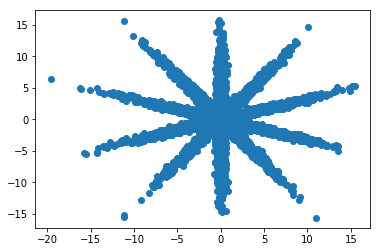

In [9]:
sess.run(test_init_op)
out = sess.run(aae.prior_data)
plt.scatter(out[:,0], out[:,1]);

### Latent space embedding of hold-out samples before training

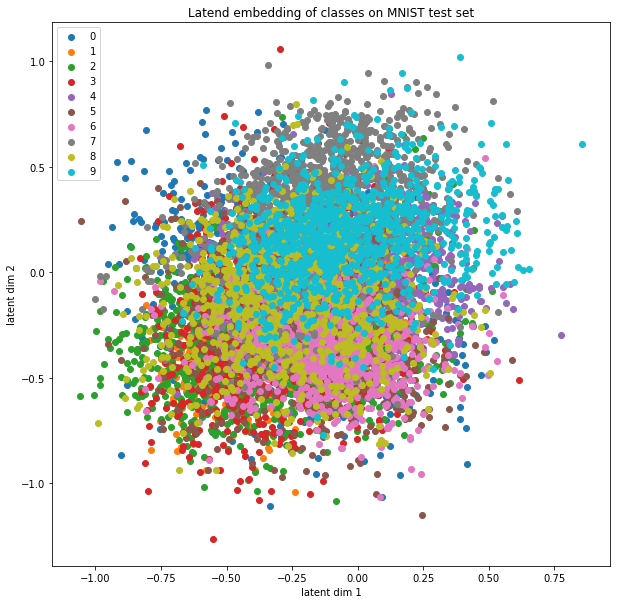

In [10]:
sess.run(test_init_op)
[x, z, x_re] = sess.run([next_element, aae.z, aae.x_re])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for g in np.unique(y_test):
    idx = np.where(y_test == g)[0]
    ax.scatter(z[idx, 0], z[idx, 1], label=g)
ax.legend()
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.title('Latend embedding of classes on MNIST test set')
plt.show()

### Training

Iter: 1
Reconstruction loss: 0.693
Discriminator loss: 1.409
Adversarial loss: 0.7192
Total runtime 1.22s

Iter: 10000
Reconstruction loss: 0.1861
Discriminator loss: 1.373
Adversarial loss: 0.7192
Total runtime 179.29s

Iter: 20000
Reconstruction loss: 0.1753
Discriminator loss: 1.371
Adversarial loss: 0.7176
Total runtime 360.02s

Iter: 30000
Reconstruction loss: 0.1818
Discriminator loss: 1.38
Adversarial loss: 0.6887
Total runtime 536.26s

Iter: 40000
Reconstruction loss: 0.1672
Discriminator loss: 1.381
Adversarial loss: 0.6949
Total runtime 712.38s

Iter: 50000
Reconstruction loss: 0.1785
Discriminator loss: 1.389
Adversarial loss: 0.7006
Total runtime 878.22s



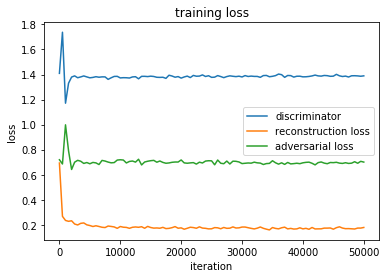

In [11]:
num_it = 50000
log_steps = 10000 #  step size for logging during training
loss_step = 500 # step size to record loss

log_step = 0
t_0 = time.time()
loss_rec = []
loss_a = []
loss_d = []
sess.run(train_init_op)
for it in range(num_it):
    
    # train ae reconstruction loss
    _, loss_rec_cur = sess.run([aae.solver_rec, aae.loss_rec])
    
    # train discriminator
    _, loss_d_cur = sess.run([aae.solver_d, aae.loss_d])
    
    # train generator adversarial loss
    _, loss_a_cur = sess.run([aae.solver_g, aae.loss_g])
    
    if (it + 1) % loss_step == 0 or it == 0:
        loss_d.append(loss_d_cur)
        loss_rec.append(loss_rec_cur)
        loss_a.append(loss_a_cur)
    
    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('Reconstruction loss: {:.4}'.format(loss_rec_cur))
        print('Discriminator loss: {:.4}'.format(loss_d_cur))
        print('Adversarial loss: {:.4}'.format(loss_a_cur))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()
        
x = np.arange(0, num_it + 1, loss_step)
plt.plot(x, loss_d, label='discriminator')
plt.plot(x, loss_rec, label='reconstruction loss')
plt.plot(x, loss_a, label='adversarial loss')
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

### Reconstruction examples

In [17]:
# results for test set samples
sess.run(test_init_op)
[x, z, x_re] = sess.run([next_element, aae.z, aae.x_re])

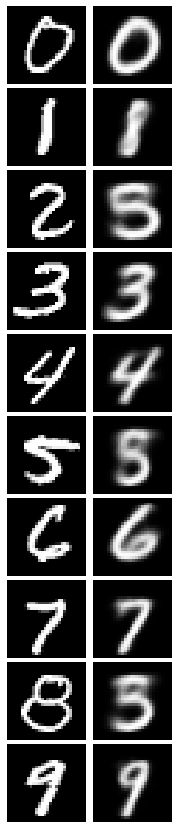

In [13]:
sample_idx = np.asarray([np.random.choice(x, 1) for x in test_cat_idx]).flatten()
tmp = np.concatenate((x[sample_idx, :].reshape((-1, 28, 28)), x_re[sample_idx, :].reshape((-1, 28, 28))))
idx = np.arange(20).reshape((2, 10)).transpose().flatten()
tmp = tmp[idx, :]
fig = plot(tmp, figsize=(3, 15), gspec=(10, 2))

### Latent space embedding of hold-out samples

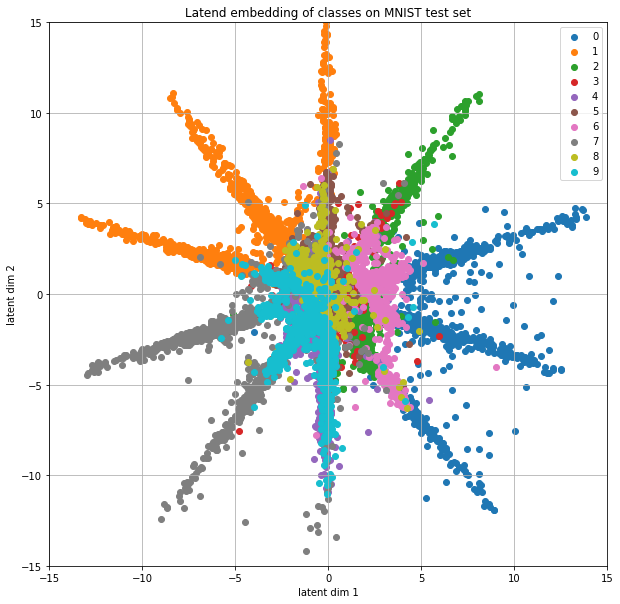

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for g in np.unique(y_test):
    idx = np.where(y_test == g)[0]
    ax.scatter(z[idx, 0], z[idx, 1], label=g)
ax.legend()
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.xlim([-15, 15]);
plt.ylim([-15, 15])
plt.title('Latend embedding of classes on MNIST test set')
plt.grid(True);
plt.show();

### Samples from the latent space

In [15]:
tmp = norm.ppf(np.arange(0.05, 1, 0.05), scale=5.)
xx, yy = np.meshgrid(tmp, tmp[::-1])
z = np.concatenate((xx.reshape((-1, 1)), yy.reshape((-1, 1))), axis=1)
samples = sess.run(aae.x_re_from_z_pl, {aae.z_pl: z})

Samples for 0.05 percentiles of a 2D Gaussian.


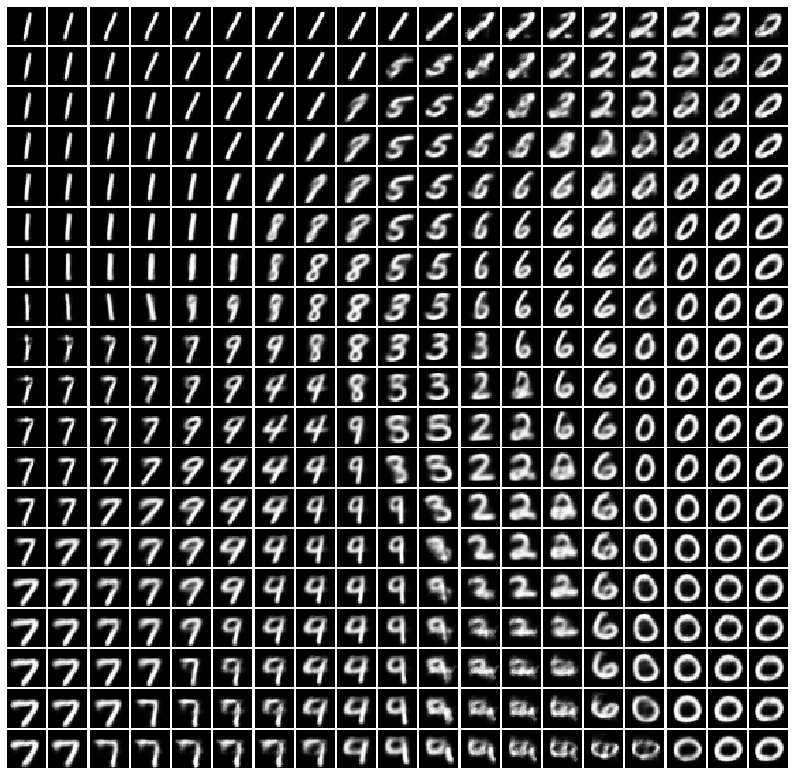

In [16]:
print('Samples for 0.05 percentiles of a 2D Gaussian.')
fig = plot(samples.reshape((-1, 28, 28)), figsize=(14, 14), gspec=(19, 19))

### Discriminator output prior and latent samples on hold-out samples

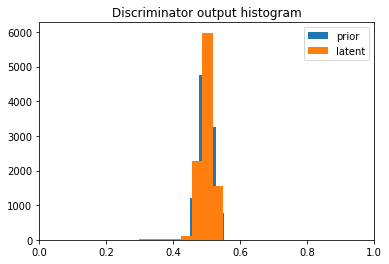

In [18]:
sess.run(test_init_op)
d_true, d_fake = sess.run([aae.d_prior_logits, aae.d_aae_logits])
d_true = 1 / (1 + np.exp(-d_true))
plt.hist(d_true, label='prior')
plt.title('Discriminator output histogram');
plt.xlim(0, 1);

d_fake = 1 / (1 + np.exp(-d_fake))
plt.hist(d_fake, label='latent')
plt.xlim(0, 1);
plt.legend();